# Dependencies

In [1]:
import scipy
from scipy.optimize import curve_fit
from scipy.io import wavfile
from scipy.signal import butter, sosfiltfilt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
import osascript
from gtts import gTTS 
from matplotlib import pylab
import os 
import pyaudio
import wave
import keyboard  # using module keyboard
import soundfile as sf
import math
import pyloudnorm as pyln
from sys import byteorder
from array import array
from struct import pack
import import_ipynb
import concat_project7

importing Jupyter notebook from concat_project7.ipynb


Using TensorFlow backend.


# Constants

In [2]:
THRESHOLD = 100
CHUNK_SIZE = 2048
FORMAT = pyaudio.paInt16
RATE = 44100
AVG_STEP = 75
PERCENTILE = 70
BANDPASS_FREQ = [300, 3400]
CALIBRATION_VOLUME = 40

# Record Audio

#### Record from microphone

In [3]:
def record():
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT, channels=1, rate=RATE,
        input=True, output=True,
        frames_per_buffer=CHUNK_SIZE)

    num_silent = 0
    snd_started = False

    r = array('h')

    while 1:
        # little endian, signed short
        snd_data = array('h', stream.read(CHUNK_SIZE))
        if byteorder == 'big':
            snd_data.byteswap()
        r.extend(snd_data)

        silent = is_silent(snd_data)

        if silent and snd_started:
            num_silent += 1
        elif not silent and not snd_started:
            snd_started = True

        if snd_started and num_silent > 60:
            break

    sample_width = p.get_sample_size(FORMAT)
    stream.stop_stream()
    stream.close()
    p.terminate()

#     r = trim(r)
#     r = add_silence(r, 0.5)
    return sample_width, r

#### Save to wav file

In [4]:
def record_to_file(path):
    sample_width, data = record()
    data = pack('<' + ('h'*len(data)), *data)

    wf = wave.open(path, 'wb')
    wf.setnchannels(1)
    wf.setsampwidth(sample_width)
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()

#### Checks if input is silent based on threshold

In [5]:
def is_silent(snd_data):
    "Returns 'True' if below the 'silent' threshold"
    return max(snd_data) < THRESHOLD

# Preprocessing

#### Trim input to remove silence at beginning and end

In [6]:
def trim(snd_data):
    def _trim(snd_data):
        snd_started = False
        r = array('h')

        for i in snd_data:
            if not snd_started and abs(i)>THRESHOLD:
                snd_started = True
                r.append(i)
            elif snd_started:
                r.append(i)
        return r

    # Trim to the left
    snd_data = _trim(snd_data)

    # Trim to the right
    snd_data.reverse()
    snd_data = _trim(snd_data)
    snd_data.reverse()
    return snd_data

#### Pad with silence at beginning and end

In [7]:
def add_silence(snd_data, seconds):
    ""
    r = array('h', [0 for i in range(int(seconds*RATE))])
    r.extend(snd_data)
    r.extend([0 for i in range(int(seconds*RATE))])
    return r

#### Process wav input with highpass filter

In [8]:
def voice_input(voice_data):
    fs, data = wavfile.read(voice_data)
    data = butter_bandpass_filter(data, BANDPASS_FREQ[0], BANDPASS_FREQ[1], fs)
    return data, fs

#### Implement butter bandpass filter

In [9]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', analog=False, output='sos')
    return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y

# Feature Extraction

# Emotion Algorithm

#### Get amplitude curve and apply regression on ITU-R BS.1770-4 loudness algorithm

In [10]:
def getting_emotion(data, rate):
    plt.figure(0)
    plt.plot(data)
    
    lol_data, fs = concat_project7.clean_sound(data, rate)

    #Convert raw data into features
    print("Data acquired")
    plt.figure(1)
    plt.plot(lol_data)
    feature_data = concat_project7.get_all_features(lol_data, fs);
    
    #return the exponential regression
    return (feature_data)

#### Remove silence before, after, and in-between voice data

In [11]:
def remove_silence_from(amplitudes, threshold):
    silenced = []
    for x in amplitudes:
        if x >= threshold:
            silenced.append(x)
    return silenced# Preprocessing

#### Regression converts loudness to scale 0 to 100 and adjusts for calibration offset

In [12]:
def regression(loudness, offset=0):
    return 2.1256619652039683 * loudness + 52.66548772500079 - offset

# Calibration

In [13]:
def get_offset(calib_loudness):
    return calib_loudness - CALIBRATION_VOLUME

# Response

#### Sets a new volume that is spoken at for the user

In [14]:
def reply(user_volume):
    speaker_volume = int(osascript.osascript('output volume of (get volume settings)')[1])
    print("speaker volume is " + str(speaker_volume))
    print("user volume is "+ str(user_volume))
    if(speaker_volume < user_volume):
        new_volume = speaker_volume + (((speaker_volume - user_volume)**2) /100)
    else:
        new_volume = speaker_volume - (((speaker_volume - user_volume)**2) /100)
    print("speaker new volume is " + str(new_volume))
    osascript.osascript("set volume output volume "+ str(new_volume)) 
    thing_to_say = 'hello your volume is at '+ str(int(new_volume))
    print(thing_to_say)
    os.system("say "+ thing_to_say)

# Main

Please speak into the microphone
done
inputted voice


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

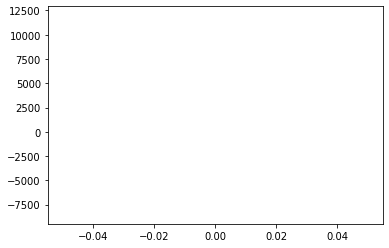

In [16]:
import time
if __name__ == '__main__':
    #calibration
    os.system("say "+ "Please speak into the microphone")
    print("Please speak into the microphone")
    record_to_file('emotion.wav')
    print("done")
    data, rate = voice_input('calibrate.wav')
    print('inputted voice')
    voice_data = getting_emotion(np.asarray([data]), rate)

    print("Your Emotion: " + str(int(your_emotion)))

In [ ]:
print(your_emotion)